In [1]:
# manual install dtv_backend (install through test_requires is not working) 
!pip install -q -e "git+https://github.com/Deltares/digitaltwin-waterway.git#egg=dtv_backend&subdirectory=dtv_backend"

Obtaining dtv_backend from git+https://github.com/Deltares/digitaltwin-waterway.git#egg=dtv_backend&subdirectory=dtv_backend
  Updating /Users/baart_f/.virtualenvs/opentnsim/src/dtv-backend clone
  Running command git fetch -q --tags
  Running command git reset --hard -q 44a20f57c7203b93bcb870fb50bdac3b816d6f61
  Preparing metadata (setup.py) ... done
  Attempting uninstall: dtv_backend
    Found existing installation: dtv-backend 0.1.0
    Uninstalling dtv-backend-0.1.0:
      Successfully uninstalled dtv-backend-0.1.0
  Running setup.py develop for dtv_backend


In [1]:
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import ipyleaflet 
import dtv_backend.fis
import opentnsim.strategy
import opentnsim.energy

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Go to the Digital Twin Vaarwegen website and click together a scenario. Export the scenario.

In [3]:
# Load the config file with all the settings
with open('../tests/data/ect-bctn.json') as f:
    config = json.load(f)
    

In [4]:
# Show the list of settings in the config file
config.keys()

dict_keys(['route', 'waypoints', 'sites', 'fleet', 'operator', 'climate', 'quantities', 'options'])

In [5]:
# Load the waypoints
waypoints_gdf = gpd.GeoDataFrame.from_features(config['waypoints'])
route_gdf = gpd.GeoDataFrame.from_features(config['route'])
fleet_gdf = gpd.GeoDataFrame.from_features(config['fleet'])
sites_gdf = gpd.GeoDataFrame.from_features(config['sites'])
bathymetry_gdf = gpd.GeoDataFrame.from_features(config['quantities']['bathymetry'])
velocities_gdf = gpd.GeoDataFrame.from_features(config['quantities']['velocities'])
waterlevel_gdf = gpd.GeoDataFrame.from_features(config['quantities']['waterlevels'])

<AxesSubplot:>

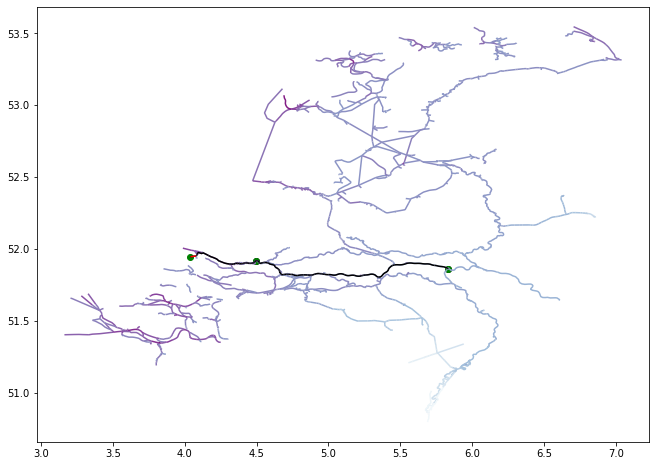

In [36]:
fig, ax = plt.subplots(figsize=(13, 8))
bathymetry_gdf.plot('nap_p50', cmap='BuPu_r', ax=ax)
route_gdf.plot(ax=ax, color='black')
waypoints_gdf.plot(ax=ax, color='green')
fleet_gdf.plot(ax=ax, color='red')

In [7]:
# take the center of the route
center_geometry = route_gdf.dissolve().centroid.iloc[0]
# lon/lat - lat/lon 
center = (center_geometry.y, center_geometry.x)

# add map
m = ipyleaflet.Map(center=center, zoom=8)

# add the layers
route_geo_data = ipyleaflet.GeoData(geo_dataframe = route_gdf, name = 'route')
m.add_layer(route_geo_data)
fleet_geo_data = ipyleaflet.GeoData(geo_dataframe = fleet_gdf, name = 'fleet', style={'color': 'red'})
m.add_layer(fleet_geo_data)

# show the map
m

Map(center=[51.87005200395497, 4.923271114583653], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [22]:
def compute_draught_load_fraction(vessel_row):
    level = 280
    capacity = 400
    filling_degree = level / capacity
    T_f = vessel_row['Draught loaded [m]']
    T_e = vessel_row['Draught empty [m]']
    T_range = T_f - T_e
    T = (T_range * filling_degree) + T_e
    return T

def create_vessel(vessel_row, **kwargs):
    model_input = {
        'L': vessel_row['Length [m]'],
        'B': vessel_row['Beam [m]'],
        'type': vessel_row['RWS-class'],
        'P_installed': float(vessel_row['Engine power maximum [kW]']),
        'L_w': 3,
        'C_year': 2000,
        'P_hotel_perc': 0.05
    }
    model_input.update(**kwargs)

    Vessel = type('Vessel', (opentnsim.core.VesselProperties, opentnsim.energy.ConsumesEnergy), {})
    vessel = Vessel(**model_input)
    return vessel

def compute_draught_dorsser(vessel_row):
    vessel = create_vessel(vessel_row)
    payload_strategy = vessel_row['Load Weight average [ton]']
    
    T = opentnsim.strategy.Payload2T(vessel=vessel, Payload_strategy=payload_strategy, vessel_type='Container')
    return T

    

In [23]:
vessel_row = fleet_gdf.iloc[0]
print('load fraction method', compute_draught_load_fraction(vessel_row))
print('dorsser method', compute_draught_dorsser(vessel_row))

# Notebook 12.


load fraction method 2.87
dorsser method 3.306212117667675


In [34]:
T = compute_draught_load_fraction(vessel_row)
vessel = create_vessel(vessel_row, T=T, P_tot_given=1800)

In [35]:
edge = {'Info': {'GeneralDepth': 3}}
opentnsim.energy.power2v(vessel, edge, upperbound=10)

3.8649135275738544

In [12]:
{
  "ship_specification": {
    "length": 135,
    "width": 11.4,
    "design_draught": 3.5
  },
  "ship_loadcase": {
    "draught": 2.5
  },
  "ship_conditions": {
    "water_depth": 10,
    "speed": [
      1,
      3,
      5,
      7
    ]
  }
}

{'ship_specification': {'length': 135, 'width': 11.4, 'design_draught': 3.5},
 'ship_loadcase': {'draught': 2.5},
 'ship_conditions': {'water_depth': 10, 'speed': [1, 3, 5, 7]}}